# Imports

In [9]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import ConstantPopulationSize, AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [1]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           calculate_parameter_sensitivity,
                           plot_parameter_sensitivity,
                           plot_regression_fit,
                           plot_parameters_kde,
                           plot_distance_weights)

INFO:myokit:Loading Myokit version 1.27.4


In [2]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [3]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create the ion channel model

In [5]:
from channels.ik1_generic import ik1 as model
model.sample({})

,x,y,exp
0,-150,-0.662984,0
1,-140,-0.832721,0
2,-130,-1.028144,0
3,-120,-1.242795,0
4,-110,-1.463968,0
5,-100,-1.672248,0
6,-90,-1.843054,0
7,-80,-1.950572,0
8,-70,-1.973190,0
9,-60,-1.898315,0


# Get experimental measurements

In [6]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Normalise as conductance is not fit in this notebook
#obs = {k: v / abs(max(obs.values(), key=abs)) for k, v in obs.items()}

In [7]:
#measurements['y'] = obs.values()

# Set limits and generate uniform initial priors

In [10]:
limits = dict(g_K1=(0,1),
              Vhalf_x=(-200,200),
              k_x=(-100,100))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Test parameter sensitivity

In [8]:
parameters = ['ik1.'+k for k in limits.keys()]

In [9]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

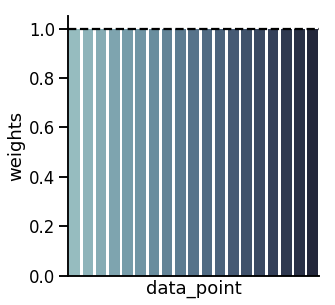

In [10]:
sns.set_context('talk')
g = plot_distance_weights(model, distance_fn)
g.savefig('results/ik1/dist_weights.pdf')

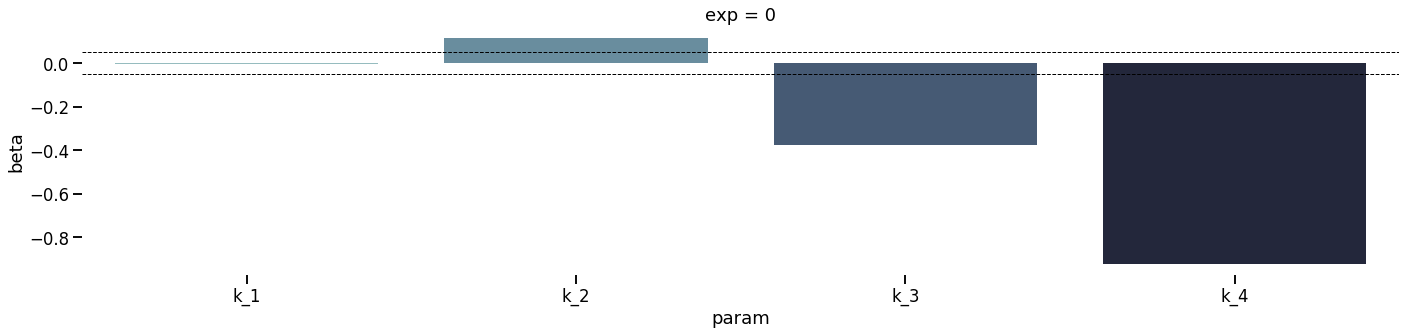

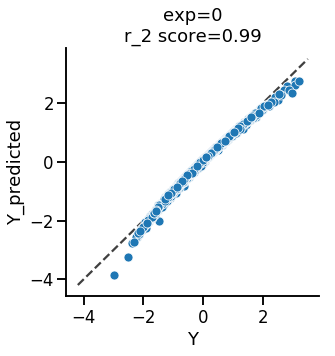

In [12]:
grid1, grid2 = plot_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.1,
    n_samples=1000,
    plot_cutoff=0.05)

In [13]:
grid1.savefig('results/ik1/sensitivity.pdf')
grid2.savefig('results/ik1/sensitivity_fit.pdf')

In [14]:
# Update limits from study
limits = dict(k_2=(0, 100),
              k_3=(0, 1),
              k_4=(0, 0.1))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Define ABC parameters and initialise database

In [11]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_ik1-generic.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_ik1-generic.db


In [12]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [13]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             population_size=ConstantPopulationSize(
                 nr_particles=2000),
             #population_size=AdaptivePopulationSize(
             #    start_nr_particles=5000,
             #    mean_cv=0.2,
             #    max_population_size=5000,
             #    min_population_size=2500),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=1),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.9999999999999999, 1: 0.9999999999999999, 2: 0.9999999999999999, 3: 0.9999999999999999, 4: 0.9999999999999999, 5: 0.9999999999999999, 6: 0.9999999999999999, 7: 0.9999999999999999, 8: 0.9999999999999999, 9: 0.9999999999999999, 10: 0.9999999999999999, 11: 0.9999999999999999, 12: 0.9999999999999999, 13: 0.9999999999999999, 14: 0.9999999999999999, 15: 0.9999999999999999, 16: 0.9999999999999999, 17: 0.9999999999999999, 18: 0.9999999999999999}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1


In [14]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2018-11-20 12:01:16.676570, end_time=None)>
INFO:Epsilon:initial epsilon is 78.69890261498134


In [24]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=30, min_acceptance_rate=0.01)

INFO:ABC:t:12 eps:6.295996622970523
DEBUG:ABC:now submitting population 12
DEBUG:ABC:population 12 done
DEBUG:ABC:
total nr simulations up to t =12 is 60980
DEBUG:Epsilon:new eps, t=13, eps=5.9414694224734
INFO:ABC:t:13 eps:5.9414694224734
DEBUG:ABC:now submitting population 13
DEBUG:ABC:population 13 done
DEBUG:ABC:
total nr simulations up to t =13 is 65190
DEBUG:Epsilon:new eps, t=14, eps=5.683339465309045
INFO:ABC:t:14 eps:5.683339465309045
DEBUG:ABC:now submitting population 14
DEBUG:ABC:population 14 done
DEBUG:ABC:
total nr simulations up to t =14 is 69322
DEBUG:Epsilon:new eps, t=15, eps=5.488708532585761
INFO:ABC:t:15 eps:5.488708532585761
DEBUG:ABC:now submitting population 15
DEBUG:ABC:population 15 done
DEBUG:ABC:
total nr simulations up to t =15 is 73413
DEBUG:Epsilon:new eps, t=16, eps=5.355034923507091
INFO:ABC:t:16 eps:5.355034923507091
DEBUG:ABC:now submitting population 16
DEBUG:ABC:population 16 done
DEBUG:ABC:
total nr simulations up to t =16 is 77574
DEBUG:Epsilon:n

KeyboardInterrupt: 

# Results analysis

In [36]:
db_path = 'sqlite:////scratch/cph211/ion-channel-ABC/docs/examples/results/ik1-generic/hl-1_ik1-generic.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-11-20 12:01:16.676570, end_time=None)>]

In [37]:
history.id = 1

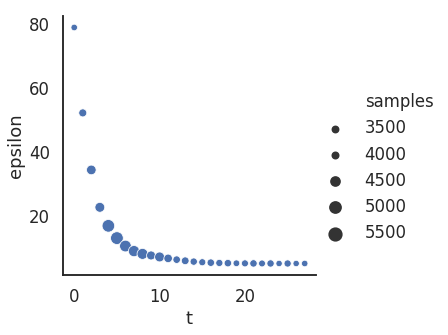

In [38]:
sns.set_context('talk')
evolution = history.get_all_populations()
grid = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
grid.savefig('results/ik1-generic/eps_evolution.pdf')

In [39]:
df, w = history.get_distribution(m=0)

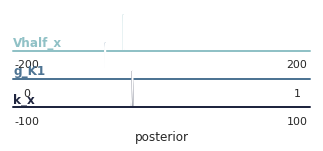

In [40]:
g = plot_parameters_kde(df, w, limits, aspect=6, height=0.8)
g.savefig('results/ik1-generic/parameters_kde.pdf')

# Samples for quantitative analysis

In [41]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [42]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

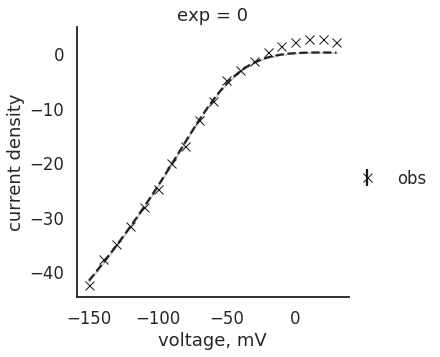

In [45]:
from ionchannelABC import plot_sim_results
sns.set_context('talk')
g = plot_sim_results(samples, obs=measurements)

# Set axis labels
xlabels = ["voltage, mV"]
ylabels = ["current density"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [46]:
g.savefig('results/ik1-generic/ik1_sim_results.pdf')